In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

from dotenv import load_dotenv
load_dotenv()

# Variables:
PROJECT_ID=os.getenv('PROJECT_ID')
BUCKET_NAME=os.getenv('BUCKET_NAME')
USER=os.getenv('USER')
LOCATION=os.getenv('LOCATION')
SERVICE_ACCOUNT=os.getenv('SERVICE_ACCOUNT')

In [ ]:
data_gcs_uri = f"gs://{BUCKET_NAME}/05_trees/CleanCreditScoring.csv"

## Trees

We'll use the **credit scoring dataset** to build a tree-based model that predicts whether a bank should lend a loan to a client or not. The problem is a binary classification problem that returns a 1 when the client should be considered a `defaulter` and the bank may not approve the loan.

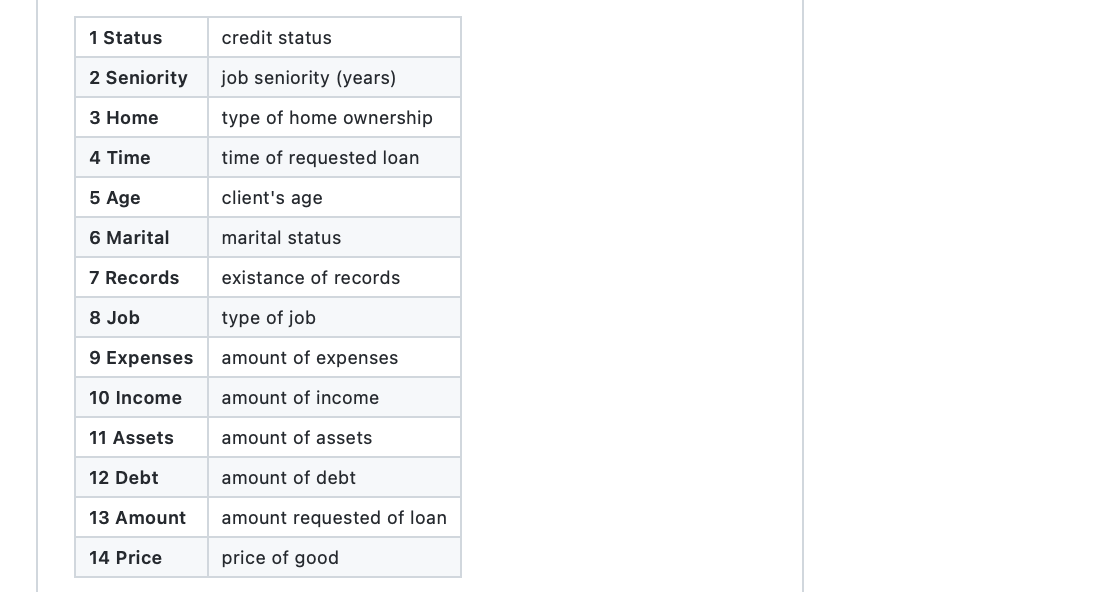

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Imports
import kfp
from kfp.dsl import (
    Input,
    Output, 
    Dataset,
    component,
    Model,
    Artifact,
    ClassificationMetrics,
)

In [ ]:
artifacts_uri = '../../artifacts/theory/05_trees/'
if not os.path.exists(artifacts_uri):
    os.makedirs(artifacts_uri)

### 1. Prepare dataset

In [ ]:
# Components
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install=[
        "gcp_python_client_functions",
    ],
)
def read_data_gcs(
    project_id: str, 
    data_gcs_uri: str,
    out_df: Output[Dataset], 
):
    import pandas as pd
    import pickle
    
    from gcp_python_client_functions.clients import Storage
    ##################### CODE:
    stg_obj = Storage(project_id)

    df = pd.read_csv(data_gcs_uri)

    # Base formatting:
    df.columns = df.columns.str.lower()
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for c in categorical_columns:
        df[c] = df[c].str.lower()
        
    # Categorical label:
    df.status = df.status=='bad'

    pd.to_pickle(df, out_df.uri + ".pkl")

read_data_gcs_func = read_data_gcs.python_func

In [ ]:
out_df = Dataset(uri = artifacts_uri +'df')

read_data_gcs_func(
    project_id = PROJECT_ID, 
    data_gcs_uri = data_gcs_uri,
    out_df = out_df,
)

df = pd.read_pickle(out_df.uri+'.pkl')

In [ ]:
df.iloc[:,:16].head()

status  seniority   home  time  age  marital  records        job  expenses  \
0   False          9   rent    60   30  married   no_rec  freelance        73   
1   False         17   rent    60   58    widow   no_rec      fixed        48   
2    True         10  owner    36   46  married  yes_rec  freelance        90   
3   False          0   rent    60   24   single   no_rec      fixed        63   
4   False          0   rent    36   26   single   no_rec      fixed        46   

   income  assets  debt  amount  price     finrat   savings  
0     129       0     0     800    846  94.562648  4.200000  
1     131       0     0    1000   1658  60.313631  4.980000  
2     200    3000     0    2000   2985  67.001675  1.980000  
3     182    2500     0     900   1325  67.924528  7.933333  
4     107       0     0     310    910  34.065934  7.083871

In [ ]:
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price',
       'finrat', 'savings', 'seniorityr', 'timer', 'ager', 'expensesr',
       'incomer', 'assetsr', 'debtr', 'amountr', 'pricer', 'finratr',
       'savingsr'],
      dtype='object')

In [ ]:
label = 'status'
categorical = ['home', 'marital', 'records','job']
numerical = ['seniority', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'time',  'savings']

### 2. Split data

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
)
def split_data(
    in_df: Input[Dataset],
    out_df_train: Output[Dataset], 
    out_df_test: Output[Dataset],
    test_size: float = 0.2,
    random_state: int = 1,
):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = pd.read_pickle(in_df.uri + ".pkl") 
    
    df_train, df_test = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
    )

    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    pd.to_pickle(df_train, out_df_train.uri + ".pkl")
    pd.to_pickle(df_test, out_df_test.uri + ".pkl")

split_data_func = split_data.python_func

In [ ]:
out_df_train = Dataset(uri = artifacts_uri +'df_train')
out_df_test = Dataset(uri = artifacts_uri +'df_test')

split_data_func(
    in_df = out_df,
    out_df_train = out_df_train, 
    out_df_test = out_df_test,
    test_size = 0.2,
    random_state = 11,
)

df_train = pd.read_pickle(out_df_train.uri+'.pkl')
df_test = pd.read_pickle(out_df_test.uri+'.pkl')

In [ ]:
out_df_train_n = Dataset(uri = artifacts_uri +'df_train_n')
out_df_val = Dataset(uri = artifacts_uri +'df_val')

split_data_func(
    in_df = out_df_train,
    out_df_train = out_df_train_n, 
    out_df_test = out_df_val,
    test_size = 0.2,
    random_state = 11,
)

df_train_n = pd.read_pickle(out_df_train_n.uri+'.pkl')
df_val = pd.read_pickle(out_df_val.uri+'.pkl')

### 3. Train Decision Tree

If, then, else rules:

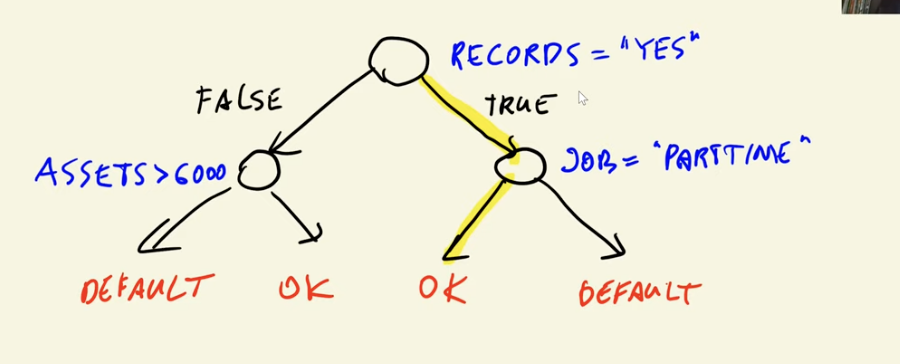

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def tree_prep_train(
    in_df_train: Input[Dataset],
    cat_features: list,
    num_features: list,
    label: str,
    out_model_pipeline: Output[Model],
    max_depth: int = None,
    min_samples_leaf: int = 1,
):
    import pandas as pd 
    import numpy as np

    import joblib
    import pickle

    from sklearn.tree import DecisionTreeClassifier
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer
    from sklearn.pipeline import make_pipeline

    df_train = pd.read_pickle(in_df_train.uri + ".pkl") 

    y_train = df_train[label].copy()
    x_train = df_train[cat_features + num_features].copy()

    def train(x_train, y_train, cat_features):
        ohe = OneHotEncoder(
                    drop='first', # Whether to drop one of the features
                    sparse=False, # Will return sparse matrix if set True
                    handle_unknown='error' # Whether to raise an error 
                ) 
        column_transform = make_column_transformer(
                    (ohe, cat_features),
                    remainder='passthrough',
                )
        dt = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        model_pipeline = make_pipeline(column_transform, dt)
        model_pipeline.fit(x_train, y_train)

        return model_pipeline
    
    model_pipeline = train(x_train, y_train, cat_features)

    with open(out_model_pipeline.uri+'.joblib', 'wb') as f:
        pickle.dump(model_pipeline, f)

tree_prep_train_func = tree_prep_train.python_func

In [ ]:
out_model_pipeline = Model(uri = artifacts_uri +'model')

label = 'status'
categorical = ['home', 'marital', 'records','job']
numerical = ['seniority', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'time',  'savings']

tree_prep_train_func(
    in_df_train = out_df_train_n,
    cat_features = categorical,
    num_features = numerical,
    label = label,
    out_model_pipeline = out_model_pipeline,
)

### 4. Evaluate model

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def evaluate(
    in_df_test: Input[Dataset], 
    cat_features: list,
    num_features: list,
    label: str,
    in_model_pipeline: Input[Model], 
    out_metrics: Output[ClassificationMetrics],
    out_df_test_preds: Output[Dataset],
) -> float:

    import pandas as pd
    import joblib
    from sklearn.metrics import roc_auc_score

    df_test = pd.read_pickle(in_df_test.uri + ".pkl") 
    model_pipeline = joblib.load(in_model_pipeline.uri + '.joblib')
    
    # Make prediction:
    y_test = df_test[label].copy()
    x_test = df_test[cat_features + num_features].copy()

    y_pred = model_pipeline.predict_proba(x_test)[:,1]
    
    # Evaluate:
    auc = roc_auc_score(y_test, y_pred)

    out_metrics.metadata = {"auc":auc}

    # Predictions:
    df_test = df_test[cat_features+num_features+[label]].copy()
    df_test[label+'_pred'] = y_pred
    pd.to_pickle(df_test, out_df_test_preds.uri + ".pkl")

    return auc

evaluate_func = evaluate.python_func

In [ ]:
out_metrics = ClassificationMetrics(uri = artifacts_uri +'metrics')
out_df_val_preds = Dataset(uri = artifacts_uri +'df_val_preds')

evaluate_func(
    in_df_test = out_df_val, 
    cat_features = categorical,
    num_features = numerical,
    label = label,
    in_model_pipeline = out_model_pipeline, 
    out_metrics = out_metrics,
    out_df_test_preds = out_df_val_preds,
)

0.681974310867369

In [ ]:
df_val_preds = pd.read_pickle(out_df_val_preds.uri+'.pkl')

In [ ]:
df_val_preds.head()

home  marital  records        job  seniority  age  expenses  income  \
0    owner   single   no_rec      fixed          1   52        35     150   
1    owner   single  yes_rec  freelance          2   19        35     184   
2    owner  married   no_rec      fixed          9   47        60      55   
3     rent   single   no_rec      fixed          0   24        63     182   
4  parents   single   no_rec      fixed          1   22        35      80   

   assets  debt  amount  price  time    savings  status  status_pred  
0    6000     0    1580   1756    60   4.367089    True          0.0  
1    9000     0     500   1100    36  10.728000    True          0.0  
2    9500     0     600   1164    60  -0.500000   False          0.0  
3    2500     0     900   1325    60   7.933333   False          0.0  
4    4000     0     600    850    30   2.250000   False          0.0

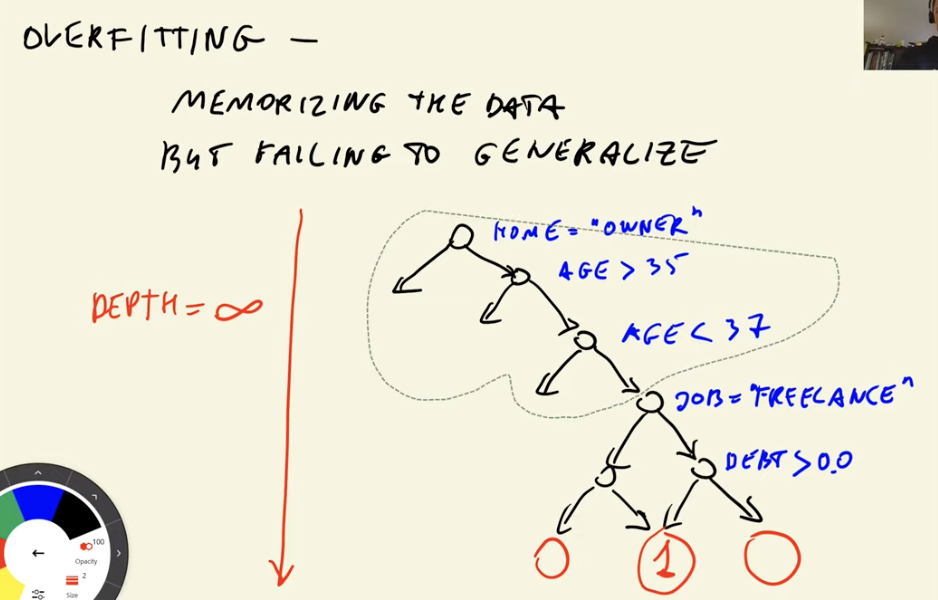

Very deep tree -> very specific rules.

In [ ]:
tree_prep_train_func(
    in_df_train = out_df_train_n,
    cat_features = categorical,
    num_features = numerical,
    label = label,
    out_model_pipeline = out_model_pipeline,
    max_depth = 3,
)
evaluate_func(
    in_df_test = out_df_val, 
    cat_features = categorical,
    num_features = numerical,
    label = label,
    in_model_pipeline = out_model_pipeline, 
    out_metrics = out_metrics,
    out_df_test_preds = out_df_val_preds,
)

0.7857170346851398

In [ ]:
from sklearn.tree import export_text
import joblib

model_pipeline = joblib.load(out_model_pipeline.uri + '.joblib')
print(export_text(model_pipeline['decisiontreeclassifier'], feature_names=model_pipeline['columntransformer'].get_feature_names_out()))




|--- onehotencoder__records_yes_rec <= 0.50
|   |--- remainder__seniority <= 2.50
|   |   |--- onehotencoder__job_partime <= 0.50
|   |   |   |--- class: False
|   |   |--- onehotencoder__job_partime >  0.50
|   |   |   |--- class: True
|   |--- remainder__seniority >  2.50
|   |   |--- remainder__income <= 99.50
|   |   |   |--- class: False
|   |   |--- remainder__income >  99.50
|   |   |   |--- class: False
|--- onehotencoder__records_yes_rec >  0.50
|   |--- remainder__seniority <= 6.50
|   |   |--- remainder__assets <= 18.00
|   |   |   |--- class: True
|   |   |--- remainder__assets >  18.00
|   |   |   |--- class: True
|   |--- remainder__seniority >  6.50
|   |   |--- onehotencoder__home_owner <= 0.50
|   |   |   |--- class: True
|   |   |--- onehotencoder__home_owner >  0.50
|   |   |   |--- class: False



### 5. Algorithm

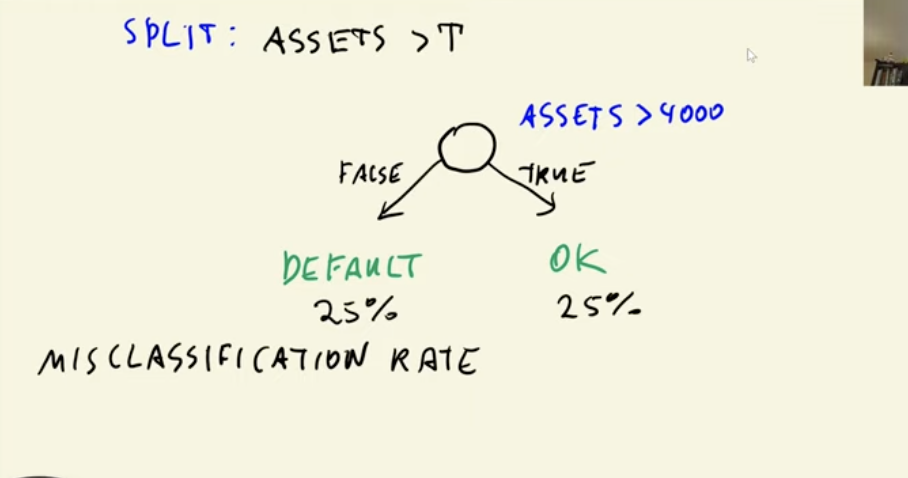

Impurity (measured with misclassification rate, entropy, gini criteria)!!! We need to find the less impure threshold for a node:

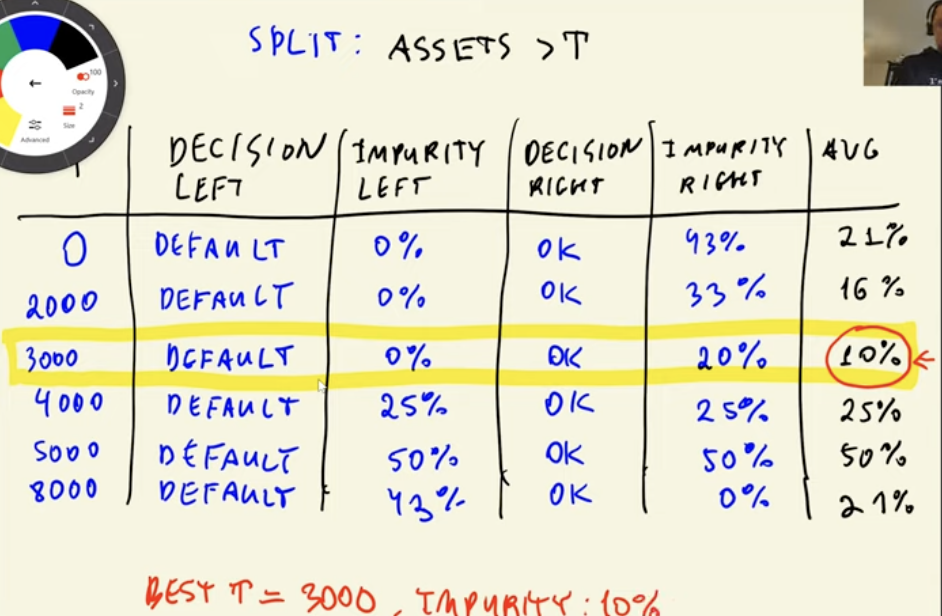

Algorithmically:
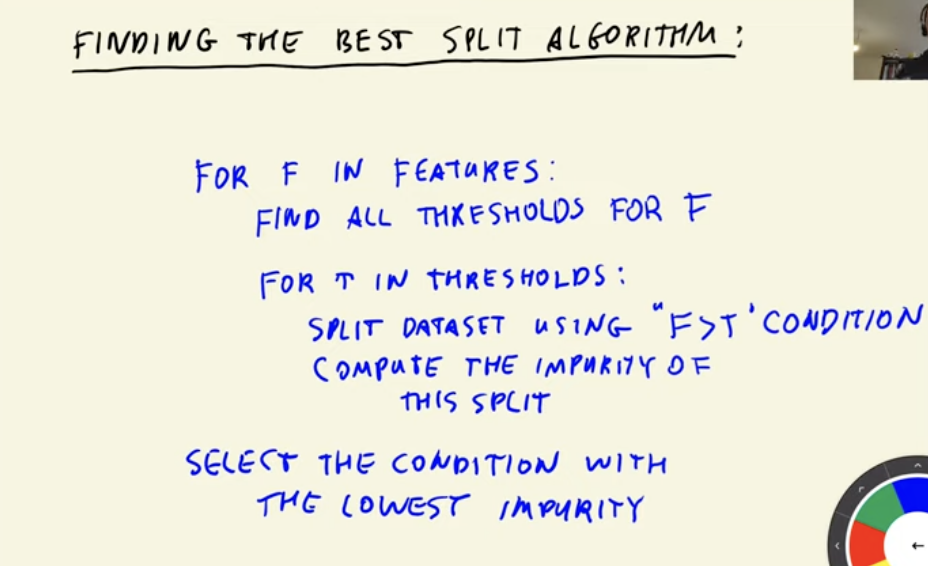

Stopping criteria?
- Group is already pure!
- Tree reached depth limit.
- Group too small (set a minimum size of the group).

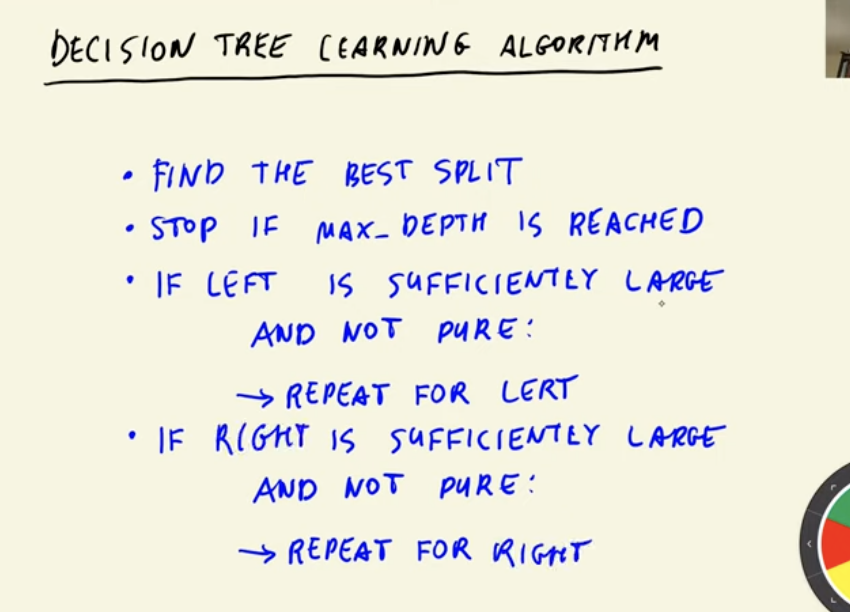

### 6. Parameter Tuning

We follow instructions in the lab:

https://codelabs.developers.google.com/vertex_hyperparameter_tuning#2

The services enabled to follow the tutorial are:

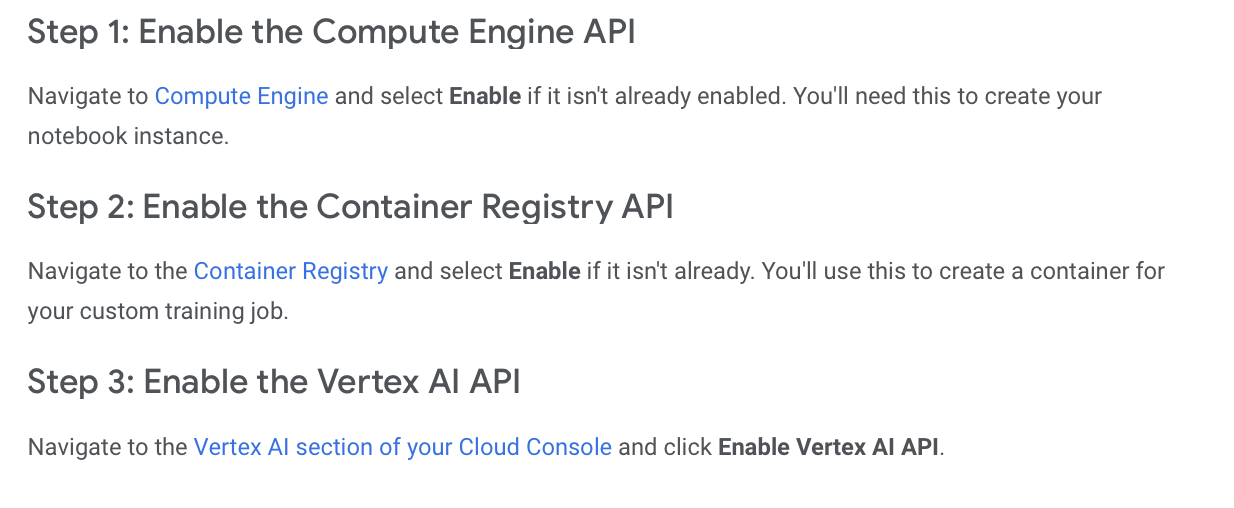

In [ ]:
def tree_train_eval(d,s):
    tree_prep_train_func(
        in_df_train = out_df_train_n,
        cat_features = categorical,
        num_features = numerical,
        label = label,
        out_model_pipeline = out_model_pipeline,
        max_depth = d,
        min_samples_leaf = s,
    )
    auc = evaluate_func(
        in_df_test = out_df_val, 
        cat_features = categorical,
        num_features = numerical,
        label = label,
        in_model_pipeline = out_model_pipeline, 
        out_metrics = out_metrics,
        out_df_test_preds = out_df_val_preds,
    )
    return auc

In [ ]:
scores = []

for d in [4,5,6,10,15,20,None]:
    for s in [1,2,5,10,15,20,100,200,500]:
        auc = tree_train_eval(d=d, s=s)
        scores.append((d,s,auc))

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.head()

max_depth  min_samples_leaf       auc
0        4.0                 1  0.790624
1        4.0                 2  0.790624
2        4.0                 5  0.790624
3        4.0                10  0.790624
4        4.0                15  0.790624

In [ ]:
df_scores.sort_values(by = 'auc', ascending = False).head()


max_depth  min_samples_leaf       auc
22        6.0                15  0.832006
23        6.0                20  0.823332
24        6.0               100  0.820874
33       10.0               100  0.820364
60        NaN               100  0.820364

In [ ]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values = ['auc'])
df_scores_pivot.round(3)

auc                                          
max_depth           NaN   4.0    5.0    6.0    10.0   15.0   20.0
min_samples_leaf                                                 
1                 0.672  0.791  0.814  0.798  0.694  0.664  0.689
2                 0.707  0.791  0.814  0.796  0.727  0.680  0.717
5                 0.765  0.791  0.802  0.800  0.782  0.741  0.763
10                0.789  0.791  0.802  0.782  0.782  0.783  0.779
15                0.796  0.791  0.815  0.832  0.808  0.797  0.801
20                0.815  0.791  0.813  0.823  0.818  0.815  0.820
100               0.820  0.800  0.819  0.821  0.820  0.820  0.820
200               0.796  0.790  0.793  0.796  0.796  0.796  0.796
500               0.721  0.721  0.721  0.721  0.721  0.721  0.721

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

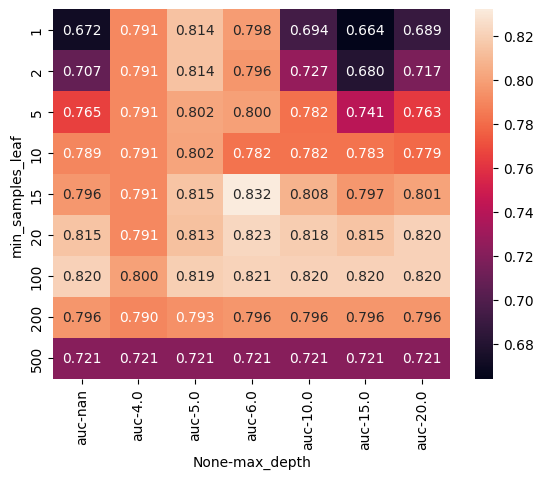

In [ ]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [ ]:
tree_prep_train_func(
    in_df_train = out_df_train,
    cat_features = categorical,
    num_features = numerical,
    label = label,
    out_model_pipeline = out_model_pipeline,
    max_depth = 6,
    min_samples_leaf = 15,
)

out_df_test_preds = Dataset(uri = artifacts_uri +'df_test_preds')
evaluate_func(
    in_df_test = out_df_test, 
    cat_features = categorical,
    num_features = numerical,
    label = label,
    in_model_pipeline = out_model_pipeline, 
    out_metrics = out_metrics,
    out_df_test_preds = out_df_test_preds,
)

0.7581872049941634

### 7. Random Forest

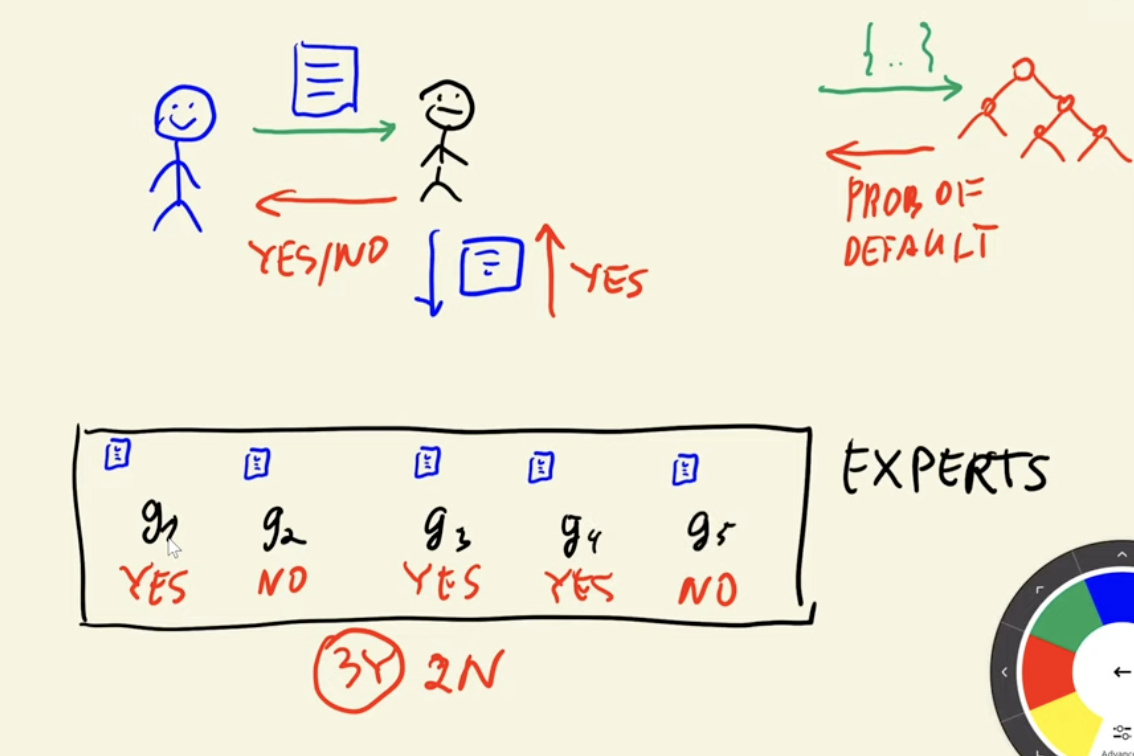

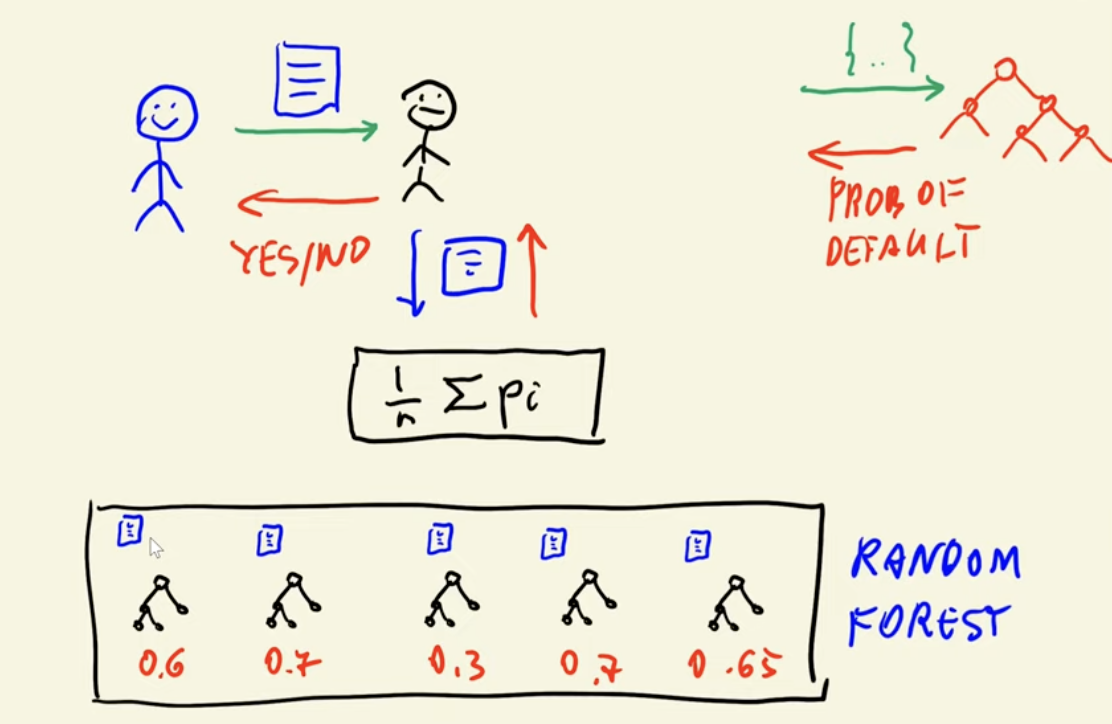

Why random? Each tree is training with a slightly different set of features (each model gets a random subset of features).

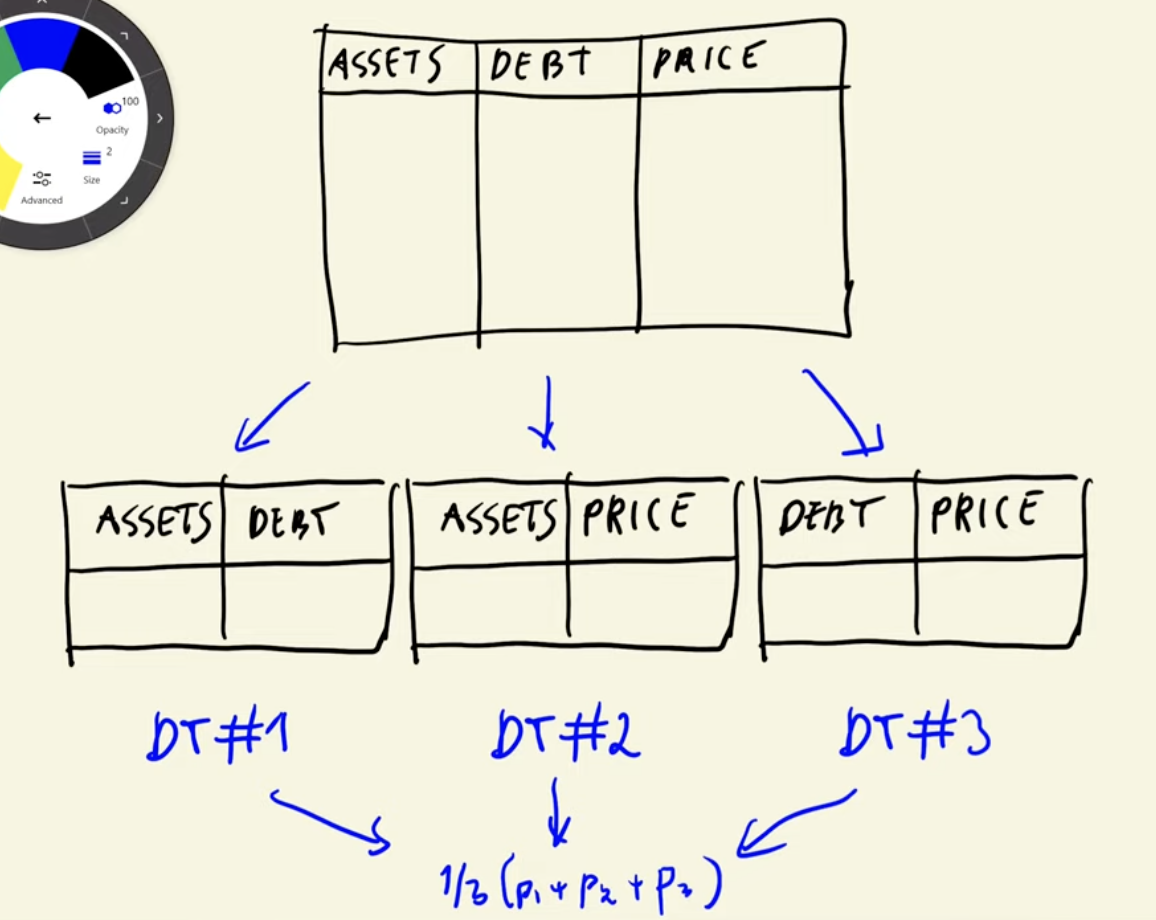

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def rf_prep_train(
    in_df_train: Input[Dataset],
    cat_features: list,
    num_features: list,
    label: str,
    out_model_pipeline: Output[Model],
    max_depth: int = None,
    min_samples_leaf: int = 1,
    n_estimators: int = 1,
    random_state: int = 1, 
):
    import pandas as pd 
    import numpy as np

    import joblib
    import pickle

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer
    from sklearn.pipeline import make_pipeline

    df_train = pd.read_pickle(in_df_train.uri + ".pkl") 

    y_train = df_train[label].copy()
    x_train = df_train[cat_features + num_features].copy()

    def train(x_train, y_train, cat_features):
        ohe = OneHotEncoder(
                    drop='first', # Whether to drop one of the features
                    sparse=False, # Will return sparse matrix if set True
                    handle_unknown='error' # Whether to raise an error 
                ) 
        column_transform = make_column_transformer(
                    (ohe, cat_features),
                    remainder='passthrough',
                )
        rf = RandomForestClassifier(
            n_estimators = n_estimators,
            random_state = random_state,
            max_depth = max_depth,
            min_samples_leaf = min_samples_leaf,
        )
        model_pipeline = make_pipeline(column_transform,rf)
        model_pipeline.fit(x_train, y_train)

        return model_pipeline
    
    model_pipeline = train(x_train, y_train, cat_features)

    with open(out_model_pipeline.uri+'.joblib', 'wb') as f:
        pickle.dump(model_pipeline, f)

rf_prep_train_func = rf_prep_train.python_func

In [ ]:
rf_prep_train_func(
    in_df_train = out_df_train_n,
    cat_features = categorical,
    num_features = numerical,
    label = label,
    out_model_pipeline = out_model_pipeline,
    n_estimators = 10,
)
evaluate_func(
    in_df_test = out_df_val, 
    cat_features = categorical,
    num_features = numerical,
    label = label,
    in_model_pipeline = out_model_pipeline, 
    out_metrics = out_metrics,
    out_df_test_preds = out_df_val_preds,
)

0.8144080434887189

In [ ]:
def rf_train_eval(n, d = None, s = 1):
    rf_prep_train_func(
        in_df_train = out_df_train_n,
        cat_features = categorical,
        num_features = numerical,
        label = label,
        out_model_pipeline = out_model_pipeline,
        max_depth = d,
        min_samples_leaf = s,
        n_estimators = n,
    )
    auc = evaluate_func(
        in_df_test = out_df_val, 
        cat_features = categorical,
        num_features = numerical,
        label = label,
        in_model_pipeline = out_model_pipeline, 
        out_metrics = out_metrics,
        out_df_test_preds = out_df_val_preds,
    )
    return auc

In [ ]:
scores = []

for d in [5,10,15]:
    for n in range(10,201,10):
        auc = rf_train_eval(d=d,n=n)
        scores.append((d,n,auc))

columns = ['max_depth', 'n_estimators', 'auc']
df_scores_rf = pd.DataFrame(scores, columns = columns)
df_scores_rf.head()

max_depth  n_estimators       auc
0          5            10  0.841815
1          5            20  0.846048
2          5            30  0.846481
3          5            40  0.847231
4          5            50  0.848780

<matplotlib.legend.Legend>

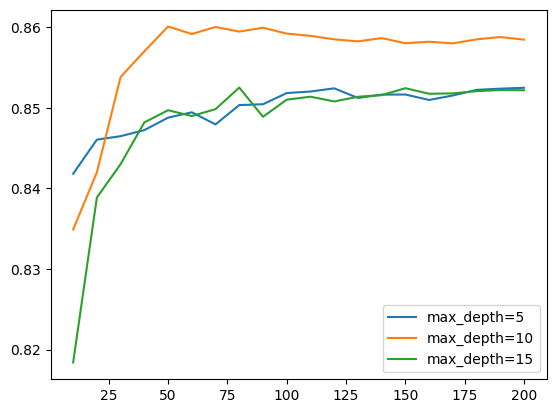

In [ ]:
for d in [5,10,15]:
    df_subset = df_scores_rf[df_scores_rf.max_depth==d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f"max_depth={d}")

plt.legend()

In [ ]:
max_depth = 10

In [ ]:
scores = []

for s in [1,3,5,10,50]:
    for n in range(10,201,10):
        auc = rf_train_eval(d=max_depth,s=s,n=n)
        scores.append((s,n,auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores_rf = pd.DataFrame(scores, columns = columns)
df_scores_rf.head()

min_samples_leaf  n_estimators       auc
0                 1            10  0.834887
1                 1            20  0.841997
2                 1            30  0.853832
3                 1            40  0.857007
4                 1            50  0.860095

<matplotlib.legend.Legend>

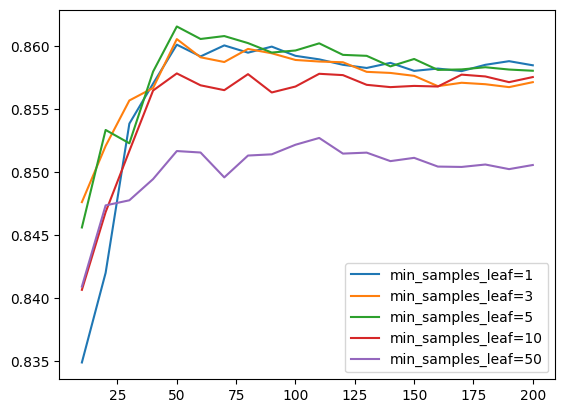

In [ ]:
for s in [1,3,5,10,50]:
    df_subset = df_scores_rf[df_scores_rf.min_samples_leaf==s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f"min_samples_leaf={s}")

plt.legend()

In [ ]:
min_samples_leaf = 5
n = 50

In [ ]:
rf_prep_train_func(
    in_df_train = out_df_train,
    cat_features = categorical,
    num_features = numerical,
    label = label,
    out_model_pipeline = out_model_pipeline,
    max_depth = max_depth,
    min_samples_leaf = min_samples_leaf,
    n_estimators = n,
)

evaluate_func(
    in_df_test = out_df_test, 
    cat_features = categorical,
    num_features = numerical,
    label = label,
    in_model_pipeline = out_model_pipeline, 
    out_metrics = out_metrics,
    out_df_test_preds = out_df_test_preds,
)

0.8138544891640866

Final random forest model.

### 8. Gradient Boosting and XGBoost

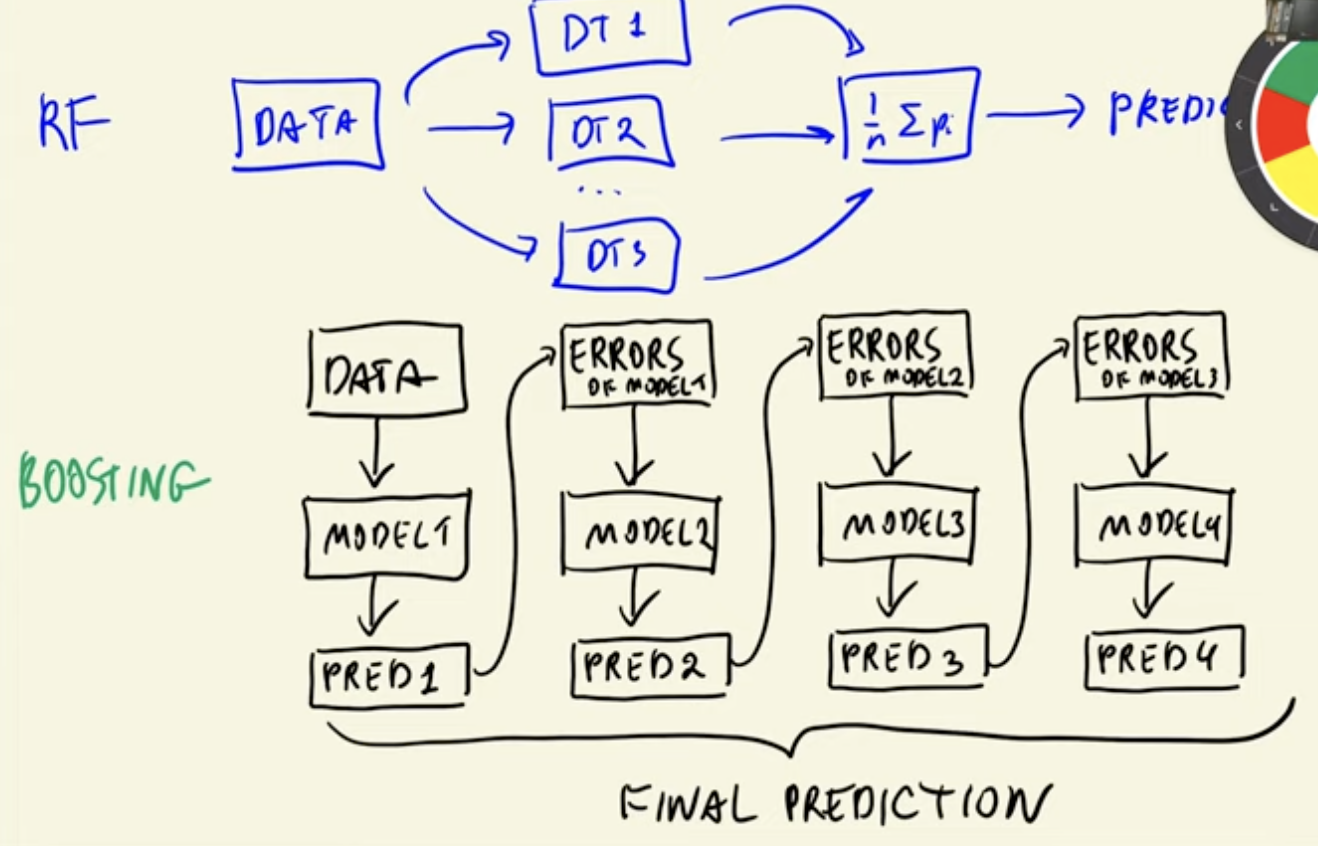

Where models are trees -> Gradient Boosting trees. Ahead we use the [Scikit-Learn XGBoost API](https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn).

In [ ]:
df_val.head()

status  seniority     home  time  age  marital  records        job  \
0    True          1    owner    60   52   single   no_rec      fixed   
1    True          2    owner    36   19   single  yes_rec  freelance   
2   False          9    owner    60   47  married   no_rec      fixed   
3   False          0     rent    60   24   single   no_rec      fixed   
4   False          1  parents    30   22   single   no_rec      fixed   

   expenses  income  ...         timer         ager    expensesr  \
0        35     150  ...  time (48,99]  age (50,99]   exp (0,40]   
1        35     184  ...  time (24,36]   age (0,25]   exp (0,40]   
2        60      55  ...  time (48,99]  age (40,50]  exp (50,60]   
3        63     182  ...  time (48,99]   age (0,25]  exp (60,80]   
4        35      80  ...  time (24,36]   age (0,25]   exp (0,40]   

         incomer              assetsr        debtr             amountr  \
0  inc (140,190]  asset (5e+03,8e+03]  debt (-1,0]  am (1.4e+03,1e+05]   
1  inc (140,190]  asset (8e+03,1e+06]  debt (-1,0]          am (0,600]   
2     inc (0,80]  asset (8e+03,1e+06]  debt (-1,0]          am (0,600]   
3  inc (140,190]      asset (0,3e+03]  debt (-1,0]        am (600,900]   
4     inc (0,80]  asset (3e+03,5e+03]  debt (-1,0]          am (0,600]   

                   pricer       finratr     savingsr  
0  priz (1.5e+03,1.8e+03]  finr (80,90]    sav (4,6]  
1    priz (1e+03,1.3e+03]   finr (0,50]   sav (6,99]  
2    priz (1e+03,1.3e+03]  finr (50,70]  sav (-99,0]  
3  priz (1.3e+03,1.5e+03]  finr (50,70]   sav (6,99]  
4          priz (0,1e+03]  finr (70,80]    sav (2,4]  

[5 rows x 27 columns]

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = [
        "scikit-learn==1.3.1",
        "xgboost==2.0.0",
    ],
)
def xgb_train(
    in_df_train: Input[Dataset],
    in_df_val: Input[Dataset],
    
    cat_features: list,
    num_features: list,
    label: str,
    
    out_xgb_model: Output[Model],
    out_column_transform: Output[Artifact],
    
    eta: float = 0.3,
    max_depth: int = 6,
    min_child_weight: int = 1,
    
    objective: str = 'binary:logistic',
    eval_metric: str = 'auc',

    n_jobs: int = 8,
    seed: int = 1, 
    verbosity: int = 1, # 0 (silent) - 3 (debug).

    n_estimators: int = 100,
    
    early_stopping_rounds: int = 5,
    verbose_early: bool = False,

    params: dict = None,
    n_iter: int = 200,
    verbose_cv: int = 1, 
    return_train_score: bool = True,
    cv: int=3,
    
):
    import pandas as pd 
    import numpy as np

    from scipy.stats import uniform, randint

    import joblib
    import pickle
    
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer
    from sklearn.pipeline import make_pipeline

    from sklearn.model_selection import GridSearchCV
    
    import xgboost as xgb

    df_train = pd.read_pickle(in_df_train.uri + ".pkl")
    y_train = df_train[label].copy()
    x_train = df_train[cat_features + num_features].copy()
    
    ohe = OneHotEncoder(
                drop='first', # Whether to drop one of the features
                sparse=False, # Will return sparse matrix if set True
                handle_unknown='error' # Whether to raise an error 
            ) 
    column_transform = make_column_transformer(
                (ohe, cat_features),
                remainder='passthrough',
            )

    x_train = column_transform.fit_transform(x_train)

    # Validation data:
    df_val = pd.read_pickle(in_df_val.uri + ".pkl")
    y_val = df_val[label].copy()
    x_val = df_val[cat_features + num_features].copy()
    x_val = column_transform.transform(x_val)
    
    xgb_model = xgb.XGBClassifier(  
        eta = eta,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        
        objective = objective,
        eval_metric = eval_metric,
        
        n_jobs = n_jobs,
        seed = seed,
        verbosity = verbosity,

        n_estimators = n_estimators,
    )

    if params:
        search = GridSearchCV(
            xgb_model, 
            param_grid=params, 
            #random_state=seed, 
            #n_iter=n_iter, 
            cv=cv, 
            verbose=verbose_cv, 
            n_jobs=n_jobs, 
            return_train_score=return_train_score,
            scoring = 'roc_auc',
        )
        search.fit(x_train, y_train)
        search_results = search.cv_results_
        eval_results = None
    else:
        xgb_model.fit(
            x_train, 
            y_train,
            early_stopping_rounds=early_stopping_rounds, 
            eval_set=[(x_train, y_train),(x_val, y_val)],
            verbose=verbose_early,
        )

        eval_results = xgb_model.evals_result()
        search_results = None

    # model_pipeline = train(x_train, y_train, cat_features)
    with open(out_xgb_model.uri+'.joblib', 'wb') as f:
        pickle.dump(xgb_model, f)
    with open(out_column_transform.uri+'.joblib', 'wb') as f:
        pickle.dump(column_transform, f)

    return eval_results, search_results

xgb_train_func = xgb_train.python_func

In [ ]:
out_xgb_model = Model(uri = artifacts_uri +'xgb_model')
out_column_transform = Artifact(uri = artifacts_uri +'column_transform')

eval_results, search_results = xgb_train_func(
    in_df_train = out_df_train_n,
    in_df_val = out_df_val,
    
    cat_features = categorical,
    num_features = numerical,
    label = label,

    out_xgb_model = out_xgb_model,
    out_column_transform = out_column_transform,
    
    n_estimators = 100,
    early_stopping_rounds = 100,
)

In [ ]:
train_auc = list(eval_results['validation_0'].values())[0]
val_auc = list(eval_results['validation_1'].values())[0]
num_iter = range(len(train_auc))

<matplotlib.legend.Legend>

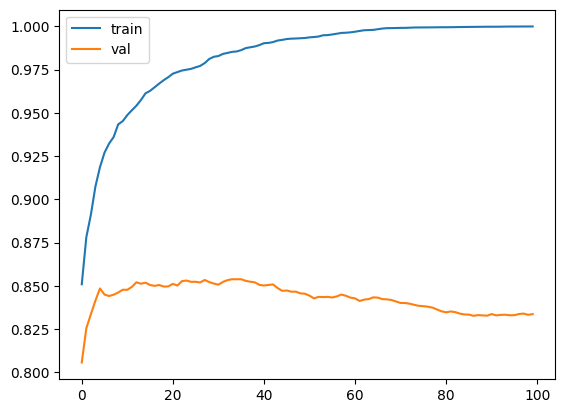

In [ ]:
plt.plot(num_iter, train_auc, label='train')
plt.plot(num_iter, val_auc, label='val')
plt.legend()

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def preprocess_evaluate(
    in_df_test: Input[Dataset], 
    
    cat_features: list,
    num_features: list,
    label: str,

    in_xgb_model: Input[Model],
    in_column_transform: Input[Artifact],
    
    out_metrics: Output[ClassificationMetrics],
    out_df_test_preds: Output[Dataset],
) -> float:

    import pandas as pd
    import joblib
    from sklearn.metrics import roc_auc_score

    df_test = pd.read_pickle(in_df_test.uri + ".pkl") 
    
    xgb_model = joblib.load(in_xgb_model.uri + '.joblib')
    column_transform = joblib.load(in_column_transform.uri + '.joblib')

    # Prerocess:
    y_test = df_test[label].copy()
    x_test = df_test[cat_features + num_features].copy()
    x_test = column_transform.transform(x_test)

    # Make prediction:
    y_pred = xgb_model.predict_proba(x_test)[:,1]
    
    # Evaluate:
    auc = roc_auc_score(y_test, y_pred)

    out_metrics.metadata = {"auc":auc}

    # Predictions:
    df_test = df_test[cat_features+num_features+[label]].copy()
    df_test[label+'_pred'] = y_pred
    pd.to_pickle(df_test, out_df_test_preds.uri + ".pkl")

    return auc

preprocess_evaluate_func = preprocess_evaluate.python_func

In [ ]:
out_metrics = ClassificationMetrics(uri = artifacts_uri +'metrics')
out_df_test_preds = Dataset(uri = artifacts_uri +'df_val_preds')

preprocess_evaluate_func(
    in_df_test = out_df_test, 
    
    cat_features = categorical,
    num_features = numerical,
    label = label,

    in_xgb_model = out_xgb_model,
    in_column_transform = out_column_transform,

    out_metrics = out_metrics,
    out_df_test_preds = out_df_test_preds,
)

0.7982096635030199

Now, tunning our parameters:

In [ ]:
from scipy.stats import uniform, randint

params = {
    "learning_rate": [.01, .05, .1, .3, 1], # default 0.1 
    #"max_depth": randint(2, 6), # default 3
    "n_estimators": range(1, 201), # default 100
}

In [ ]:
eval_results, search_results = xgb_train_func(
    in_df_train = out_df_train_n,
    in_df_val = out_df_val,
    
    cat_features = categorical,
    num_features = numerical,
    label = label,

    out_xgb_model = out_xgb_model,
    out_column_transform = out_column_transform,
    
    n_estimators = 100,
    early_stopping_rounds = 100,

    params = params,
)

In [ ]:
search_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [ ]:
search_results_pd = pd.DataFrame(search_results["params"])
search_results_pd['mean_test_score'] = search_results['mean_test_score']
search_results_pd['mean_train_score'] = search_results['mean_train_score']
search_results_pd

learning_rate  n_estimators  mean_test_score  mean_train_score
0             0.01             1         0.760400          0.859609
1             0.01             2         0.760679          0.861147
2             0.01             3         0.761714          0.861502
3             0.01             4         0.762002          0.864073
4             0.01             5         0.762286          0.864241
..             ...           ...              ...               ...
995           1.00           196         0.771592          1.000000
996           1.00           197         0.771362          1.000000
997           1.00           198         0.771455          1.000000
998           1.00           199         0.771616          1.000000
999           1.00           200         0.771404          1.000000

[1000 rows x 4 columns]

<matplotlib.legend.Legend>

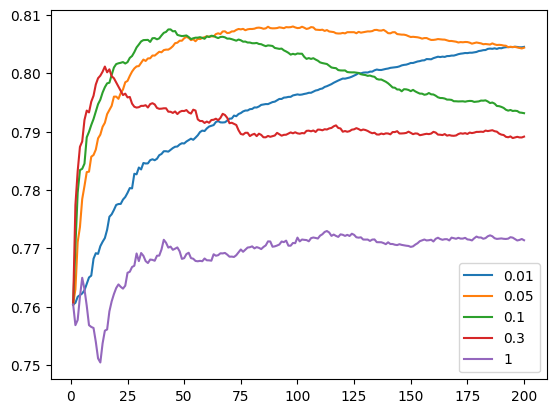

In [ ]:
for eta in params['learning_rate']:
    df_sub = search_results_pd[search_results_pd.learning_rate==eta]
    plt.plot(params['n_estimators'], df_sub.mean_test_score, label=eta)
plt.legend()

In [ ]:
df_best_eta = search_results_pd[search_results_pd.learning_rate==0.1]
max_auc = df_best_eta.mean_test_score.max()
df_best_eta=df_best_eta[df_best_eta.mean_test_score==max_auc]
df_best_eta

learning_rate  n_estimators  mean_test_score  mean_train_score
443            0.1            44         0.807528          0.973683

In [ ]:
params = {
    "max_depth": [6, 3, 4, 10],
}

eval_results_1, search_results_1 = xgb_train_func(
    in_df_train = out_df_train_n,
    in_df_val = out_df_val,
    
    cat_features = categorical,
    num_features = numerical,
    label = label,

    out_xgb_model = out_xgb_model,
    out_column_transform = out_column_transform,

    eta = 0.1,
    n_estimators = 44,

    params = params,
)

In [ ]:
search_results_pd_1 = pd.DataFrame(search_results_1["params"])
search_results_pd_1['mean_test_score'] = search_results_1['mean_test_score']
search_results_pd_1['mean_train_score'] = search_results_1['mean_train_score']
search_results_pd_1

max_depth  mean_test_score  mean_train_score
0          6         0.807528          0.973683
1          3         0.813967          0.892194
2          4         0.816718          0.923169
3         10         0.797933          0.999655

In [ ]:
params = {
    "min_child_weight": [1, 10, 30, 10],
}
eval_results_2, search_results_2 = xgb_train_func(
    in_df_train = out_df_train_n,
    in_df_val = out_df_val,
    
    cat_features = categorical,
    num_features = numerical,
    label = label,

    out_xgb_model = out_xgb_model,
    out_column_transform = out_column_transform,

    eta = 0.1,
    n_estimators = 44,
    max_depth = 3,

    params = params,
)

In [ ]:
search_results_pd_2 = pd.DataFrame(search_results_2["params"])
search_results_pd_2['mean_test_score'] = search_results_2['mean_test_score']
search_results_pd_2['mean_train_score'] = search_results_2['mean_train_score']
search_results_pd_2

min_child_weight  mean_test_score  mean_train_score
0                 1         0.813967          0.892194
1                10         0.816506          0.879935
2                30         0.816815          0.863615
3                10         0.816506          0.879935

In [ ]:
_,_ = xgb_train_func(
    in_df_train = out_df_train_n,
    in_df_val = out_df_val,
    
    cat_features = categorical,
    num_features = numerical,
    label = label,

    out_xgb_model = out_xgb_model,
    out_column_transform = out_column_transform,

    eta = 0.1,
    n_estimators = 44,
    max_depth = 3,
    min_child_weight = 30,
)

In [ ]:
preprocess_evaluate_func(
    in_df_test = out_df_test, 
    
    cat_features = categorical,
    num_features = numerical,
    label = label,

    in_xgb_model = out_xgb_model,
    in_column_transform = out_column_transform,

    out_metrics = out_metrics,
    out_df_test_preds = out_df_test_preds,
)

0.8218006141196773

### 9. Choosing a Model

0.7581872049941634, 0.8138544891640866, **0.8218006141196773**